In [1]:
import numpy as np
import torch
import json
import matplotlib.pyplot as plt

/home/luck/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
from smuc_kitchen.training import train_model
from smuc_kitchen.utils.get_device import get_device
import smuc_kitchen.utils.save_load

In [3]:
# fix random seeds
SEED = 600
torch.manual_seed(SEED)
np.random.seed(SEED)

# define path to dataset, can contain multiple files in the list
data_path = ['./Data/participant_labeling/300_viktor_12-04-2024, 16:05:31.json', './smuc_kitchen/data/Full-Data-80-20-split-6-kitchens-6000.json', './smuc_kitchen/data/output.json']

# get device
device = get_device()

In [4]:
# define hyperparameters for training
NUM_EPOCHS = 1000 # number of training epochs
LR = 0.00017 # learning rate
LAYERS = [128, 64, 32] # number of features in each layer of the network.

# train model
model, summary = train_model(
    data_paths=data_path,
    lr=LR,
    epochs=NUM_EPOCHS,
    layers=LAYERS
    )

loaded 240 examples from ./Data/participant_labeling/300_viktor_12-04-2024, 16:05:31.json
loaded 7608 examples from ./smuc_kitchen/data/Full-Data-80-20-split-6-kitchens-6000.json
loaded 55609 examples from ./smuc_kitchen/data/output.json
loaded 60 examples from ./Data/participant_labeling/300_viktor_12-04-2024, 16:05:31.json
loaded 1902 examples from ./smuc_kitchen/data/Full-Data-80-20-split-6-kitchens-6000.json
loaded 13903 examples from ./smuc_kitchen/data/output.json
Total number of training examples: 63457
Total number of test examples: 15865
Start training
Device: cpu
Number of epochs: 1000
Number of training examples: 63457


100%|██████████| 1000/1000 [18:36<00:00,  1.12s/it]


In [5]:
# print the training summary
print(summary)



Summary
datetime: .................. 2024-04-13_11:22:24
num_training_examples: ..... 63457
epochs: .................... 1000
batch_size: ................ 1024
lr: ........................ 0.00017
num_kitchens: .............. 6
num_food_items: ............ 15
final_accuracy: ............ 60.781593322753906
model_name: ................ 


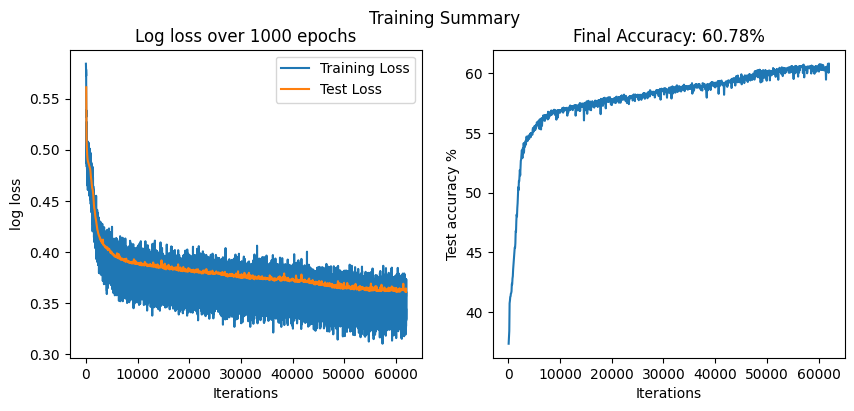

In [6]:
# display the final plot
fig = summary.summary_plot
# the plot can be saved using savefig
# fig.savefig('test_figure')
fig

In [3]:
# save model with summary
model_path = './trained_models/6_kitchen_2'
smuc_kitchen.utils.save_load.save_summary(model_path, summary)

NameError: name 'summary' is not defined

Second part: Load a trained model and use it to compute assignments.

1. load model
2. classify
```
trained_model, _ = utils.save_load.load_model_for_inference(PATH)
assignment = classify.classify(trained_model, x, 'one_hot') 
```
classify() works with lists, numpy arrays and torch tensors. Just make sure, the dimensions are correct. The most general input shape is [batch_size, num_kitchens + 1, num_items]. Specify the output format by passing for example 'one_hot' or 'label' to the classify method, see examples below. 

In [7]:
# load trained model to perform inference
trained_model, loaded_summary = smuc_kitchen.utils.save_load.load_model_for_inference(model_path)

# print training summary
print(loaded_summary)

# print model architecture
print('Model architecture:')
print(trained_model)

# show training plot
loaded_summary.summary_plot

Loaded summary from: ./trained_models/6_kitchen_2


Summary
datetime: .................. 2024-04-11_01:07:06
num_training_examples: ..... 55609
epochs: .................... 800
batch_size: ................ 512
lr: ........................ 0.00019
num_kitchens: .............. 6
num_food_items: ............ 15
final_accuracy: ............ 73.03459930419922
model_name: ................ 
Model architecture:
SimplestMLP(
  (net): Sequential(
    (0): Linear(in_features=105, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=56, bias=True)
    (3): ReLU()
    (4): Linear(in_features=56, out_features=6, bias=True)
    (5): Softmax(dim=1)
  )
)


<Figure size 1000x400 with 2 Axes>

In [10]:
# load full data from json file and convert to numpy arrays
f = open(data_path[0])
full_data = json.load(f)
food_data = np.array(full_data['food_data_train'])  # [num_examples, num_kitchens + 1, num_items]
true_assignments = np.array(full_data['kitchens_data_train'])  # [num_examples, num_kitchens]

In [12]:
from smuc_kitchen.classify import classify
# classify full dataset and compute accuracy
pred = classify(trained_model, food_data, 'label')
accuracy = np.sum(np.where(pred - np.argmax(true_assignments, axis=1) == 0, 1, 0)) / len(food_data) * 100
print(f'Accuracy over training dataset: {accuracy :.2f}%')

Accuracy over training dataset: 20.01%


In [13]:
# generate a single test example with dimensions [num_kitchens + 1, num_items]
num_kitchens = loaded_summary.num_kitchens
num_items = loaded_summary.num_food_items

# random kitchen inventory
means = np.mean(food_data, axis=0)[:num_kitchens, :]
stds = np.std(food_data, axis=0)[:num_kitchens, :]
random_inventory = stds * np.random.randn(num_kitchens, num_items) + means

# one hot item to distribute
random_item_to_distribute = np.zeros(num_items)
random_item_to_distribute[np.random.choice(num_items)] = 100

# combine inventory and item to distribute
test_input = np.vstack((random_inventory, random_item_to_distribute))
print(f'Shape of test input: {test_input.shape}')

Shape of test input: (7, 15)


In [14]:
# Compute assignments with different output encodings
assignment_default = classify(trained_model, test_input)
print(f'Assignments with probabilities: {assignment_default}')

assignment_one_hot = classify(trained_model, test_input, 'one_hot')
print(f'Assignments one hot encoded: {assignment_one_hot}')

assignment_label = classify(trained_model, test_input, 'label')
print(f'Assignments with kitchen labels: {assignment_label}')

Assignments with probabilities: [0. 0. 1. 0. 0. 0.]
Assignments one hot encoded: [0 0 1 0 0 0]
Assignments with kitchen labels: 2
